In [1]:
!pip install wordcloud
!pip install numpy
!pip install pandas


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from wordcloud import WordCloud


import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import time
import unicodedata

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from bokeh.plotting import figure
from bokeh.tile_providers import get_provider, WIKIMEDIA, CARTODBPOSITRON, STAMEN_TERRAIN, STAMEN_TONER, ESRI_IMAGERY, OSM
from bokeh.io import output_notebook, show

import warnings

warnings.filterwarnings("ignore")
pd.set_option("max_columns", 30)

output_notebook()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhann\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading BokehJS ...

Getting Data

Make sure that all files are in your working directory before running the code below

In [2]:
# create separate dataframes from data
df_atlanta=pd.read_json('atlanta.json')
df_austin=pd.read_json('austin.json')
df_chicago=pd.read_json('chicago.json')
df_houston=pd.read_json('houston.json')
df_la=pd.read_json('la.json')
df_ny=pd.read_json('ny.json')
df_oc=pd.read_json('oc.json')
df_sandiego=pd.read_json('sd.json')
df_seattle=pd.read_json('seattle.json')
df_sf=pd.read_json('sf.json')


# function to update locations to main city name, all axcept 'United States'
def update_location(dataframe, updated_location):
    dataframe['location'] = np.where(~dataframe['location'].str.contains("United States", na=False), updated_location, dataframe['location'])

#update locations
update_location(df_atlanta, 'atlanta, ga')
update_location(df_austin, 'austin, tx')
update_location(df_chicago, 'chicago, il')
update_location(df_houston, 'houston, tx')
update_location(df_la, 'los angeles, ca')
update_location(df_ny, 'new york, ny')
update_location(df_oc, 'orange county, ca')
update_location(df_sandiego, 'san diego, ca')
update_location(df_seattle, 'seattle, wa')
update_location(df_sf, 'san francisco, ca')

#combine all to one dataframe
df=pd.concat([df_atlanta,df_austin,df_chicago, df_houston, df_la, df_ny, df_oc, df_sandiego, df_seattle, df_sf],axis=0) 


In [3]:
df

,positionName,company,location,reviews,url,id,postedAt,scrapedAt,description
0,Accounting Specialist - Data Compliance Analyst,IST Management Services,"atlanta, ga",345,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,ad52fb67440e3d78,5 days ago,2021-10-27T04:23:39.403Z,Overview:\n\nWe are seeking a candidate to joi...
1,Data Analyst (Virtual - Work from Home),Alight,"atlanta, ga",726,https://www.indeed.com/rc/clk?jk=a169d6639ed36...,a169d6639ed360ca,4 days ago,2021-10-27T04:23:41.199Z,Alight unlocks enterprise growth for the world...
2,"Supply Chain Data Analyst (100% Remote, Must w...",The Mom Project,"atlanta, ga",,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,5fe84c8f0804f354,Just posted,2021-10-27T04:23:41.808Z,Our Global Manufacturing client is a seeking S...
3,Data Analyst,Hash Technologies,"atlanta, ga",,https://www.indeed.com/company/Hash-Technologi...,d22c9c410442bc5d,1 day ago,2021-10-27T04:23:42.958Z,Job Description: * Strong problem solving ski...
4,Data Analyst (Contractor),Diversified Sourcing Solutions,"atlanta, ga",70,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,1ba7f397c2fa1c91,4 days ago,2021-10-27T04:23:43.444Z,The successful candidate will turn data into i...
...,...,...,...,...,...,...,...,...,...
570,nCino Business Analyst - Remote working USA,Platform 6 Ltd,United States,,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,03d89b1c7c416107,18 days ago,2021-10-27T02:59:16.481Z,Our client is looking for an nCino Business An...
571,Field Data Collection Analyst,SWCA Environmental Consultants,United States,46,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,a7ae7c11a14076c5,15 days ago,2021-10-27T02:59:16.646Z,About the opportunity:\n\nSWCA is looking for ...
572,Life and Annuity Senior Business Analyst,Majesco- Insurance/Software,United States,,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,793b8691d1ce5afe,30+ days ago,2021-10-27T02:59:16.685Z,"Our Purpose\nAt Majesco, we believe in connect..."
573,Data Systems Analyst,Computershare,United States,1063,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,dd75b09102944bed,Just posted,2021-10-27T02:59:16.875Z,Location. Remote – United States\nWe give you ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cleaning

In [4]:

# drop unnecessary columns
df = df.drop(columns=['reviews', 'id', 'postedAt', 'scrapedAt', 'url'])

# make lowercase
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

# delete duplicate rows
df = df.drop_duplicates()

# create senior jobs
senior = df[((df['positionName'].str.contains('senior'))
             | (df['positionName'].str.contains('sr.')))]

# all remote jobs (positionName has either 'remote' or 'virtual')
remote = df[(df['positionName'].str.contains('remote')) | (
    df['positionName'].str.contains('virtual')) | (df['location'].str.contains('united states'))]

# check for any NaN values
df.isnull().values.any()

remote.head()


,positionName,company,location,description
1,data analyst (virtual - work from home),alight,"atlanta, ga",alight unlocks enterprise growth for the world...
2,"supply chain data analyst (100% remote, must w...",the mom project,"atlanta, ga",our global manufacturing client is a seeking s...
12,business analyst (remote),marriott - atlanta nw,"atlanta, ga",job title: business/operational analyst\ndepar...
40,data analyst (us remote),leantaas,"atlanta, ga",we are a series d company that’s on a mission ...
43,business analyst -- (remote),matlen silver,"atlanta, ga",job title: business analyst\nlocation: remote\...


In [5]:
senior

,positionName,company,location,description
28,sr. data analyst,cstech,"atlanta, ga",pim data analystthe future is what you make it...
53,senior analyst – data adoption,the coca-cola company,"atlanta, ga",job description summary:\nthe coca-cola compan...
59,"senior data analyst, cash app",cash app,"atlanta, ga",company description\n\nit all started with an ...
67,"sr analyst, data",neiman marcus,"atlanta, ga",the role\nneiman marcus technology is seeking ...
71,sr data analyst,at&t,"atlanta, ga",overall purpose: this career step requires sen...
...,...,...,...,...
479,"senior manager/associate director, commercial ...",myovant sciences,"san francisco, ca",myovant sciences aspires to be the leading hea...
481,"sr director, it enterprise data and analytics ...",gilead sciences,"san francisco, ca",gilead sciences is continuing to hire for all ...
482,senior sales strategy manager (senior manager ...,walmart,"san francisco, ca",position summary...\nwhat you'll do...\nat wal...
500,senior data science analyst,jm talent inc.,"san francisco, ca",this role provides an opportunity to leverage ...


In [6]:
# drop senior rows
df_nonsenior = (pd.merge(df,senior, indicator=True, how='outer')
         .query('_merge=="left_only"')
         .drop('_merge', axis=1))



DATA EXPLORATION

In [7]:
# remote vs in person

remote_chart = remote.groupby('location').count()
remote_chart = remote_chart.drop(columns=['company', 'description'])
remote_chart = remote_chart.rename(columns={'positionName':'count_remote'})
remote_chart.reset_index()

df_chart = df.groupby('location').count()
df_chart = df_chart.drop(columns=['company', 'description'])
df_chart = df_chart.rename(columns={'positionName':'count_all'})
df_chart.reset_index()

df_remote_and_all= df_chart.merge(remote_chart, how='inner', on='location')

df_remote_and_all = df_remote_and_all.drop(index='united states')

df_remote_and_all

,count_all,count_remote
location,,
"atlanta, ga",702,36
"austin, tx",357,22
"chicago, il",756,34
"houston, tx",378,16
"los angeles, ca",578,19
"new york, ny",830,33
"orange county, ca",328,10
"san diego, ca",230,6
"san francisco, ca",475,10


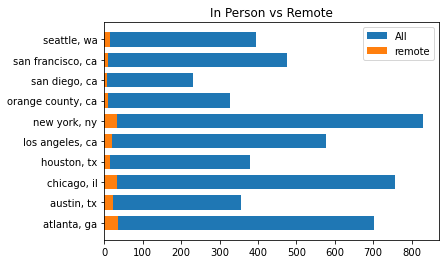

In [9]:
labels = df_remote_and_all.index

width = 0.7   

fig, ax = plt.subplots()


ax.barh(labels, df_remote_and_all['count_all'], width, label='All')
ax.barh(labels, df_remote_and_all['count_remote'], width, label='remote')


ax.set_title('In Person vs Remote')
ax.legend()


plt.show()

In [8]:
# Visual representation of locations 

df_map = df_nonsenior.groupby('location').count()
df_map = df_map.drop(columns=['company', 'description'])
df_map = df_map.rename(columns={'positionName':'count'})

df_map = df_map.sort_values(by='count',ascending=False)

df_map['Latitude'] = [40.7128, 41.8781, 33.7490, 34.0522, 37.7749, 29.7604, 47.6062, 30.2672, 33.7175, 32.7157, 37.0902]
df_map['Longitude'] = [-74.0060, -87.6298, -84.3880, -118.2437, -122.4194, -95.3698, -122.3321, -97.7431, -117.8311, -117.1611, -95.7129]


from pyproj import Proj, transform
inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')


lons, lats = [], []
for lon, lat in list(zip(df_map["Longitude"], df_map["Latitude"])):
    x, y = transform(outProj,inProj,lon,lat)
    lons.append(x)
    lats.append(y)
    

df_map["MercatorX"] = lons
df_map["MercatorY"] = lats   

wikimedia = get_provider(WIKIMEDIA)
cartodb = get_provider(CARTODBPOSITRON)

us_lon1, us_lat1 = transform(outProj,inProj,-140,10)
us_lon2, us_lat2 = transform(outProj,inProj,-50,55)

p = figure(plot_width=800, plot_height=600,
           x_range=(us_lon1, us_lon2), y_range=(us_lat1, us_lat2),
           x_axis_type="mercator", y_axis_type="mercator",
           tooltips=[
                    ("location", "@location"), ("count", "@count"), ("(Long, Lat)", "(@Longitude, @Latitude)")
                    ],
           title="Data Analyst Job Postings")

p.add_tile(cartodb)

p.circle(x="MercatorX", y="MercatorY",
         size=20,
         fill_color="tomato", line_color="tomato",
         fill_alpha=0.3,
         source=df_map,
         )

show(p)


Text(0.5, 1.0, 'Jobs per City')

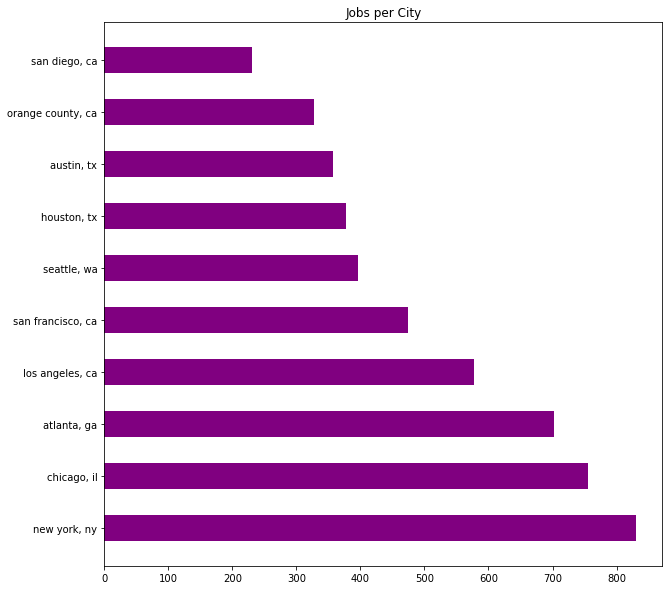

In [10]:
# bar chart of number of jobs per city

df_map_chart = df_remote_and_all.drop(columns = 'count_remote')
df_map_chart = df_map_chart.sort_values(by='count_all',ascending=False)

plt.figure(figsize=(10,10))
plt.barh(df_map_chart.index,df_map_chart['count_all'], height = 0.5, color='purple')

plt.title("Jobs per City")

In [11]:
# Create list of skills (each skill group is divieded into 1 or 2 word list)

list1_1 = [('sql',) , ('mysql',) , ('python',), ('oracle',), ('sybase',), ('tableau',), ('nosql',), ('weka',), ('r',), ('hadoop',), ('sas',), ('spss',), ('matlab',)]
list1_2 = [('microsoft', 'excel'), ('google', 'analytics'), ('power', 'bi')]
list2_1 = [('mathematics',), ('etl',), ('statistical',), ('database',),('vlookup',),('querying',),('testing',),('reporting',),('dashboards',)]
list2_2 = [('data', 'modeling'), ('data', 'collection'), ('data', 'cleaning'), ('data', 'visualization'), ('pattern', 'recognition'), ('machine', 'learning'), ('data', 'processing'), ('data', 'mining'), ('business', 'analysis'), ('business', 'strategy'), ('big', 'data'), ('predictive', 'analysis'), ('data', 'extraction'),('data','warehousing')]
list3_1 = [('communication,'), ('collaboration,'), ('presentation,'),('troubleshoot')]
list3_2 = [('critical', 'thinking'), ('public', 'speaking'), ('attention', 'detail'), ('problem', 'solving'), ('project', 'management'), ('team', 'work'), ('decision', 'making'), ('logical', 'thinking')]

N - GRAMS

In [12]:
# n - grams set up / preprocess

def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = unicodedata.normalize('NFKD', text).lower()
  words = re.sub(r'[^\w\s]', '', text).split()

  return [wnl.lemmatize(word) for word in words if word not in stopwords]


words = basic_clean(''.join(str(df_nonsenior['description'].tolist())))




Uni Grams

In [13]:
# 1 grams - does NOT provide sufficient information 

uni_grams = pd.Series(nltk.ngrams(words, 1)).value_counts()[:1000000000].to_frame()

uni_grams = uni_grams.rename(columns={0: 'counts'})



uni_grams.head(20)

#uni_grams.to_excel("uni_grams.xlsx",
             #sheet_name='uni_grams') 



,counts
"(data,)",28528
"(business,)",18365
"(team,)",10713
"(experience,)",10647
"(work,)",10541
"(management,)",7234
"(analysis,)",6958
"(process,)",6834
"(project,)",6735
"(skill,)",6372


In [14]:
# find SPECIFIC uni grams from the list1_1

df_list1_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list1_1:
        df_list1_1 = df_list1_1.append(uni_grams.loc[[x], :])
        
df_list1_1 = df_list1_1.reset_index()          

df_list1_1.head(100)

,index,counts
0,"(sql,)",2325
1,"(tableau,)",1170
2,"(python,)",817
3,"(r,)",537
4,"(oracle,)",445
5,"(spss,)",137
6,"(mysql,)",59
7,"(hadoop,)",48
8,"(nosql,)",30
9,"(matlab,)",21


In [15]:
# find SPECIFIC uni grams from the list2_1

df_list2_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list2_1:
        df_list2_1 = df_list2_1.append(uni_grams.loc[[x], :])
        
df_list2_1 = df_list2_1.reset_index()        

df_list2_1.head(100)

,index,counts
0,"(reporting,)",3972
1,"(database,)",2041
2,"(testing,)",1551
3,"(statistical,)",1244
4,"(mathematics,)",490
5,"(etl,)",349
6,"(querying,)",130
7,"(vlookup,)",41


In [16]:
# find SPECIFIC uni grams from the list3_1

df_list3_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list3_1:
        df_list3_1 = df_list3_1.append(uni_grams.loc[[x], :])
        
df_list3_1 = df_list3_1.reset_index()        

df_list3_1.head(100)

,index


BI GRAMS

In [17]:
# 2 grams

two_grams = pd.Series(nltk.ngrams(words, 2)).value_counts()[:10000000].to_frame()
two_grams.reset_index()

two_grams = two_grams.rename(columns={0: 'counts'})
 

two_grams.head(20)

#two_grams.to_excel("two_grams.xlsx",
             #sheet_name='two_grams')  

# provides good amount of information


,counts
"(year, experience)",2211
"(data, analyst)",1709
"(business, analyst)",1673
"(equal, opportunity)",1543
"(sexual, orientation)",1469
"(national, origin)",1427
"(data, analysis)",1420
"(gender, identity)",1244
"(opportunity, employer)",1204
"(data, analytics)",1105


In [18]:
# find SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          

df_list1_2.head(100)

,index,counts
0,"(power, bi)",521
1,"(microsoft, excel)",245
2,"(google, analytics)",126


In [19]:
# find SPECIFIC bi grams from the list2_2

df_list2_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list2_2:
        df_list2_2 = df_list2_2.append(two_grams.loc[[x], :])
        
df_list2_2 = df_list2_2.reset_index()          

df_list2_2.head(100)

,index,counts
0,"(data, visualization)",837
1,"(business, analysis)",491
2,"(data, collection)",394
3,"(machine, learning)",273
4,"(data, mining)",247
5,"(data, modeling)",244
6,"(data, warehousing)",174
7,"(big, data)",154
8,"(business, strategy)",136
9,"(data, processing)",81


In [20]:
# find SPECIFIC bi grams from the list3_2

df_list3_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list3_2:
        df_list3_2 = df_list3_2.append(two_grams.loc[[x], :])
        
df_list3_2 = df_list3_2.reset_index()          

df_list3_2.head(100)

,index,counts
0,"(project, management)",861
1,"(attention, detail)",503
2,"(problem, solving)",469
3,"(critical, thinking)",275
4,"(decision, making)",243
5,"(team, work)",153
6,"(public, speaking)",10
7,"(logical, thinking)",4


TRI GRAMS

In [21]:
# 3 grams - NOT USING, BUT CAN STILL MENTION: does NOT provide more information than 2 grams
three_grams = pd.Series(nltk.ngrams(words, 3)).value_counts()[:10000000].to_frame()
three_grams.head(20)

#three_grams.to_excel("three_grams.xlsx",
             #sheet_name='three_grams')  


,0
"(equal, opportunity, employer)",1087
"(sexual, orientation, gender)",844
"(without, regard, race)",764
"(race, color, religion)",753
"(orientation, gender, identity)",743
"(regard, race, color)",644
"(employment, without, regard)",555
"(equal, employment, opportunity)",499
"(receive, consideration, employment)",474
"(color, religion, sex)",471


In [27]:
# create 3 data frame with different skill types

df_tool = pd.DataFrame()
df_hard = pd.DataFrame()
df_soft = pd.DataFrame()

#TOOL SKILLS
df_tool = df_tool.append(df_list1_1)
df_tool = df_tool.append(df_list1_2)
df_tool = df_tool.sort_values(by='counts',ascending=False)

tool_list = ['sql', 'tableau', 'python', 'r', 'power bi', 'oracle', 'microsoft excel','spss', 'google analytics', 'mysql','hadoop', 'nosql', 'matlab','sybase', 'weka']
df_tool = df_tool.rename(columns={'index':'skill'})
df_tool['skill'] = tool_list

#HARD SKILLS
df_hard = df_hard.append(df_list2_1)
df_hard = df_hard.append(df_list2_2)
df_hard = df_hard.sort_values(by='counts',ascending=False)

hard_list = ['reporting','database','testing','statistical','data visualization', 'business analysis', 'mathematics', 'data collection', 'etl', 'machine learning' , 'data mining', 'data modeling', 'data warehousing', 'big data', 'business strategy','querying', 'data processing', 'data extraction', 'data cleaning', 'vlookup','predictive analysis', 'pattern recognition']
df_hard = df_hard.rename(columns={'index':'skill'})
df_hard['skill'] = hard_list

#SOFT SKILLS
df_soft = df_soft.append(df_list3_1)
df_soft = df_soft.append(df_list3_2)
df_soft = df_soft.sort_values(by='counts',ascending=False)

soft_list = ['project management', 'attention to detail', 'problem solving', 'critical thinking', 'decision making', 'team work', 'public speaking', 'logical thinking']
df_soft = df_soft.rename(columns={'index':'skill'})
df_soft['skill'] = soft_list

df_tool.head(10)

,skill,counts
0,sql,2325
1,tableau,1170
2,python,817
3,r,537
0,power bi,521
4,oracle,445
1,microsoft excel,245
5,spss,137
2,google analytics,126
6,mysql,59


TOOL SKILLS visualization

<Figure size 432x288 with 0 Axes>

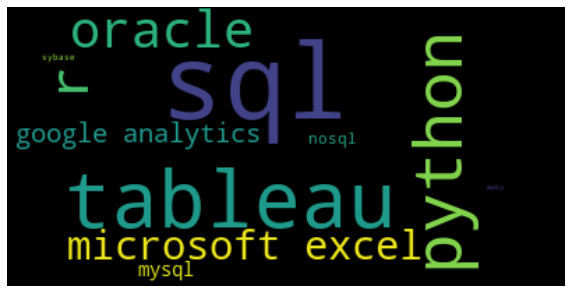

In [28]:
# word cloud
d_tool = dict(zip(df_tool.skill, df_tool.counts))


wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_tool)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Tool Skills')

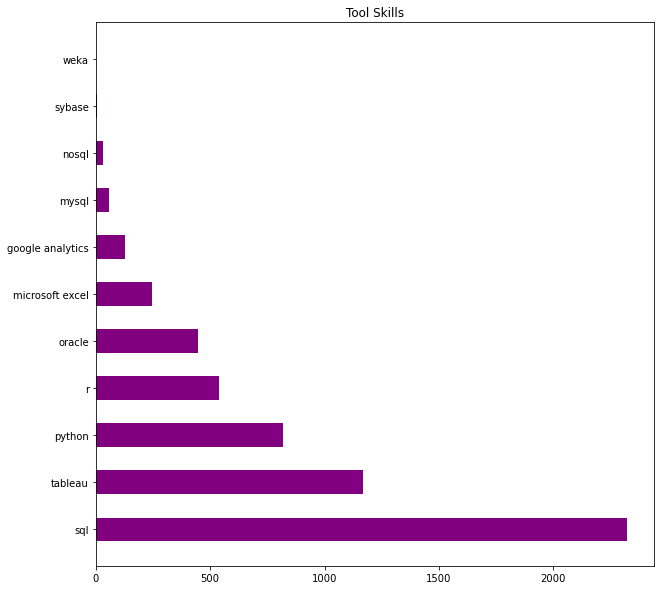

In [29]:
# bar chart

plt.figure(figsize=(10,10))
plt.barh(df_tool['skill'],df_tool['counts'], height = 0.5, color='purple')

plt.title("Tool Skills")


HARD SKILLS visualization

<Figure size 432x288 with 0 Axes>

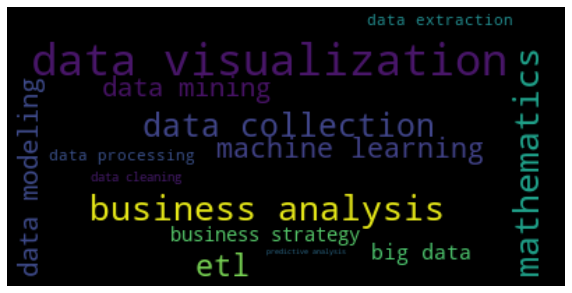

In [30]:
# word cloud
d_hard = dict(zip(df_hard.skill, df_hard.counts))


wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_hard)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [38]:
df_hard.head(10)

,skill,counts
0,data visualization,837
1,business analysis,491
0,mathematics,490
2,data collection,394
1,etl,349
3,machine learning,273
4,data mining,247
5,data modeling,244
6,big data,154
7,business strategy,136


Text(0.5, 1.0, 'Hard Skills')

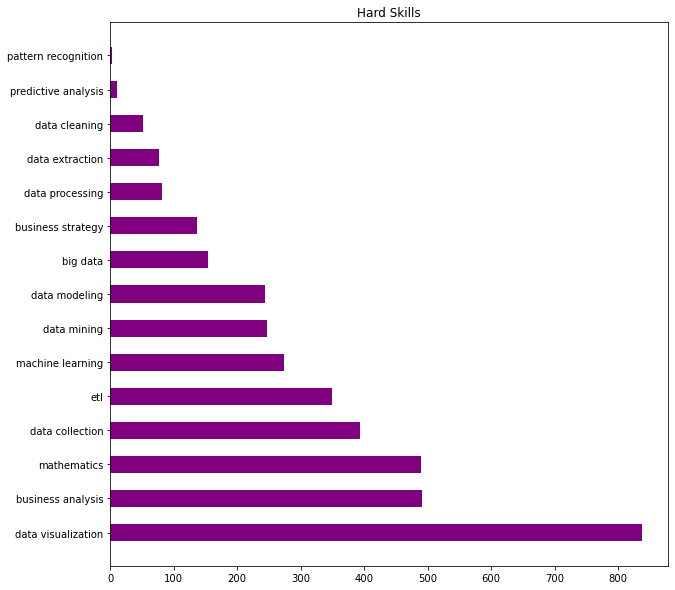

In [31]:
# bar chart

plt.figure(figsize=(10,10))
plt.barh(df_hard['skill'],df_hard['counts'], height = 0.5, color='purple')

plt.title("Hard Skills")


SOFT SKILLS visualization

<Figure size 432x288 with 0 Axes>

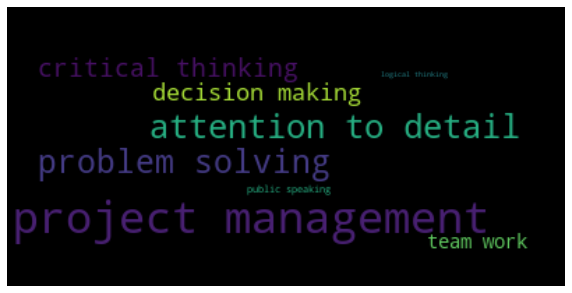

In [32]:
# word cloud
d_soft = dict(zip(df_soft.skill, df_soft.counts))


wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_soft)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [39]:
df_soft.head(10)

,skill,counts
0,project management,861.0
1,attention to detail,503.0
2,problem solving,469.0
3,critical thinking,275.0
4,decision making,243.0
5,team work,153.0
6,public speaking,10.0
7,logical thinking,4.0


Text(0.5, 1.0, 'Soft Skills')

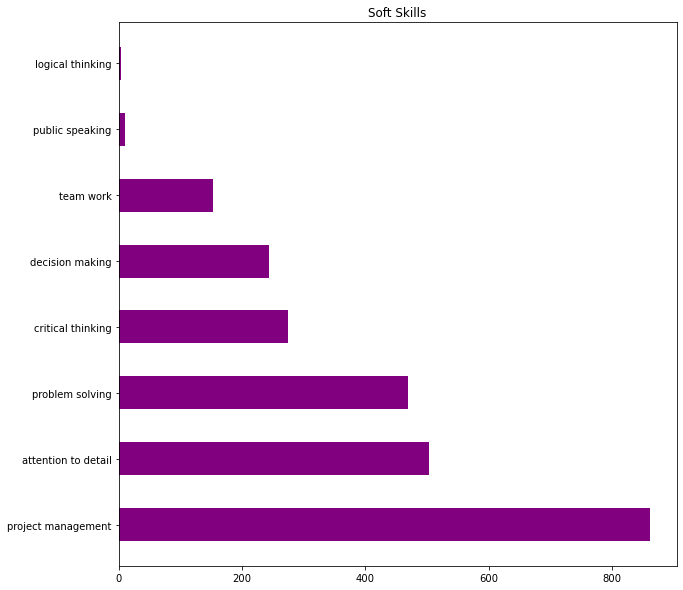

In [33]:
# bar chart

plt.figure(figsize=(10,10))
plt.barh(df_soft['skill'],df_soft['counts'], height = 0.5, color='purple')

plt.title("Soft Skills")


Combining all n grams together

In [28]:
#create df with all skills

df_skills = pd.DataFrame()

df_skills = df_skills.append(df_tool)
df_skills = df_skills.append(df_hard)
df_skills = df_skills.append(df_soft)

df_skills = df_skills.sort_values(by='counts',ascending=False)


df_skills.head(100)

,skill,counts
0,reporting,3972.0
0,sql,2325.0
1,database,2041.0
2,testing,1551.0
3,statistical,1244.0
1,tableau,1170.0
0,project management,861.0
0,data visualization,837.0
2,python,817.0
3,r,537.0


visualization of ALL SKILLS

<Figure size 432x288 with 0 Axes>

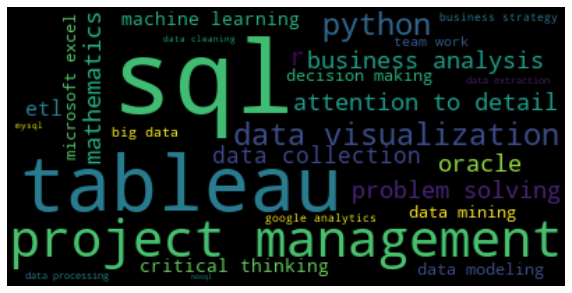

In [35]:

# word cloud


d = dict(zip(df_skills.skill, df_skills.counts))


import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'All Skills')

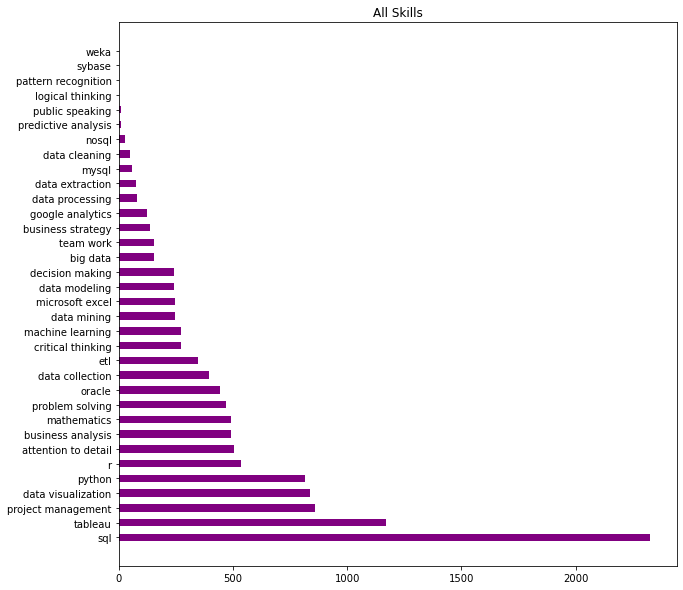

In [36]:
# bar chart
plt.figure(figsize=(10,10))
plt.barh(df_skills['skill'],df_skills['counts'], height = 0.5, color='purple')

plt.title("All Skills")
